<a href="https://colab.research.google.com/github/quangphuc2509/AI-Homework/blob/main/gender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from PIL import Image
from keras import layers, models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from IPython.display import clear_output
import pathlib

In [2]:
dataset_url = r"/content/drive/MyDrive/FinalProject/Gendertrain2"
data_dir = pathlib.Path(dataset_url)

batch_size = 32
img_height = 100
img_width = 100

In [3]:
# Tạo file train với tỉ lệ 80% file data
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_url,
  validation_split = 0.2,
  subset = "training",
  seed = 125,
  image_size = (img_height, img_width),
  batch_size = batch_size,
  color_mode= "rgb")

# Tạo file test với tỉ lệ 20% file data
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_url,
  validation_split = 0.2,
  subset = "validation",
  seed = 125,
  image_size = (img_height, img_width),
  batch_size = batch_size,
  color_mode= "rgb")

Found 2004 files belonging to 2 classes.
Using 1604 files for training.
Found 2004 files belonging to 2 classes.
Using 400 files for validation.


In [4]:
# lấy tên các thư mục để làm nhãn cho dữ liệu train
class_names = train_ds.class_names
print(class_names)

['man', 'woman']


In [5]:
# kiểm tra kiểu dữ liệu trong dữ liệu train
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 100, 100, 3)
(32,)


In [7]:
num_classes = len(class_names)
# Tạo mô hình Sequential
model = Sequential()
# Chuẩn hóa giá trị pixel từ 0-255 về 0-1
model.add(Rescaling(1./255))

# Tạo lớp Convolution với bộ lọc 3x3, activation là hàm phi tuyến
model.add(Conv2D(64, kernel_size = 3, activation = "relu", 
                 input_shape = (100, 100, 3), padding = "same"))
model.add(Conv2D(64, kernel_size = 3, activation = "relu", padding = "same"))
model.add(MaxPooling2D((2, 2), padding = "same"))

model.add(Conv2D(128, kernel_size = 3, activation = "relu", padding = "same"))
model.add(Conv2D(128, kernel_size = 3, activation = "relu", padding = "same"))
model.add(MaxPooling2D((2, 2), padding = "same"))

model.add(Conv2D(256, kernel_size = 3, activation = "relu", padding = "same"))
model.add(Conv2D(256, kernel_size = 3, activation = "relu", padding = "same"))
model.add(MaxPooling2D((2, 2), padding = "same"))

model.add(Conv2D(512, kernel_size = 3, activation = "relu", padding = "same"))
model.add(Conv2D(512, kernel_size = 3, activation = "relu", padding = "same"))
model.add(MaxPooling2D((2, 2), padding = "same"))


# Chuyển đổi đầu ra các lớp convolution thành mảng 1 chiều
model.add(Flatten())

# Tạo lớp ẩn
model.add(Dense(1000, activation = 'relu'))
model.add(Dense(num_classes, activation = 'softmax'))

# Biên dịch Mô hình, ở đây sử dụng SparseCategoricalCrossentropy để tính toán mất mát của mô hình
# dựa trên xác suất dự đoán của mô hình và chỉ số của lớp thực sự của dữ liệu.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [8]:
# Tạo hàm callback, Trong đó
# class chứa câu lệnh được thực hiện khi két thúc 1 epoch
class DisplayCallback(Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True) # Xóa nội dung hiện tại trên console

# EarlyStopping: dừng quá trình train sớm nếu mô hình không cải thiện độ chính xác 
#               trên tập validation trong một số epoch liên tiếp (patience)
# ReduceLROnPlateau: giảm learning rate nếu độ chính xác trên tập validation 
#                 không cải thiện trong một số epoch liên tiếp
# ModelCheckpoint: lưu trữ các check point tốt nhất sau mỗi epoch
callbacks = [DisplayCallback(), 
            EarlyStopping(patience=10, verbose=1),                  
            ReduceLROnPlateau(patience=5, verbose=1),
            ModelCheckpoint('/content/drive/MyDrive/FinalProject/genderdetect_final_3.h5', 
                            verbose=1, save_best_only=True)]

In [9]:
# train mô hình 
history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs = 100,
                    callbacks = callbacks)


Epoch 40: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 40: val_loss did not improve from 0.23733
51/51 [==============================] - 5s 93ms/step - loss: 0.0467 - accuracy: 0.9882 - val_loss: 0.3042 - val_accuracy: 0.8950 - lr: 1.0000e-05
Epoch 40: early stopping


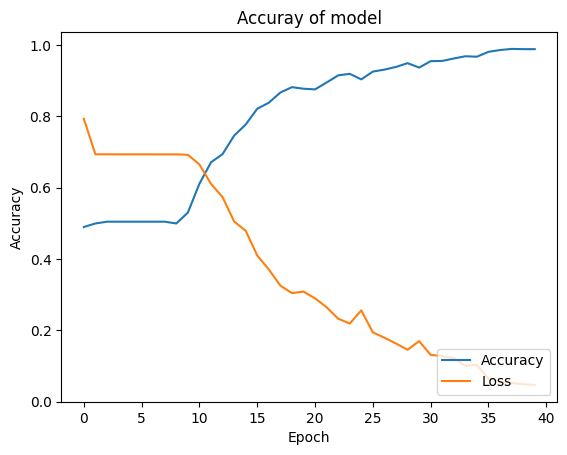

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"])
plt.title("Accuray of model")

plt.ylabel("Accuracy")
plt.xlabel("Epoch")

plt.legend(["Accuracy", "Loss"], loc = "lower right")

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 100, 100, 64)      1792      
                                                                 
 conv2d_9 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 50, 50, 128)       73856     
                                                                 
 conv2d_11 (Conv2D)          (None, 50, 50, 128)       147584    
                                                      